In [1]:
import pandas as pd
import numpy as np
import operator
import json

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("admission_data.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,242,317,103,2,2.5,2.0,8.15,0,0.65
1,334,319,108,3,3.0,3.5,8.54,1,0.71
2,4,322,110,3,3.5,2.5,8.67,1,0.80
3,45,326,113,5,4.5,4.0,9.40,1,0.91
4,232,319,106,3,3.5,2.5,8.33,1,0.74


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']],
    data[['Chance of Admit']],
    test_size=0.2,
    random_state=0)

In [4]:
for col in X_train:
    mean = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mean)/std
    X_test[col] = (X_test[col]-mean)/std

In [5]:
X_train['Ones'] = [1]*len(X_train)
X_test['Ones'] = [1]*len(X_test)

In [6]:
def sigmoid(Z):
    return 1.0/(1.0 + np.exp(-Z))

In [7]:
class LogisticRegression:
    
    theta = None
    threshold = 0.72
    
    def set_threshold(self,t):
        self.threshold = t
    
    def convert_to_class(self, target_list):
        return map((lambda a : 0 if a<=self.threshold else 1), target_list)
        #data['COA_logistic'] = map((lambda a : 0 if a<=0.72 else 1), (list(data['Chance of Admit'].values)))
    
    def compute_precision_recall_f1score(self, y_actual, y_predict):
        y_actual = self.convert_to_class(y_actual)
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for i in range(0,len(y_actual)):
            if y_actual[i]==0 and y_predict[i]==0:
                #true negative
                tn += 1
            if y_actual[i]==0 and y_predict[i]==1:
                #false positive
                fp += 1
            if y_actual[i]==1 and y_predict[i]==0:
                #false negative
                fn += 1
            if y_actual[i]==1 and y_predict[i]==1:
                #true positive
                tp += 1
        precision = float(tp)/(float(tp)+float(fp))
        recall = float(tp)/(float(tp)+float(fn))
        f1score = 2.0/((1.0/float(precision)) + (1.0/float(recall)))
        return (precision,recall,f1score)
    
    def compute_accuracy(self,y_actual, y_predict):
        y_actual = self.convert_to_class(list(y_actual))
        y_predict = list(y_predict)
        hits = 0
        for i in range(0,len(y_actual)):
            if y_actual[i] == y_predict[i]:
                hits+=1
        return float(hits)/float(len(y_actual))
    
    def predict(self, X):
        Y_pred = list(sigmoid(np.dot(X.values,self.theta.T)))
        Y_pred = self.convert_to_class(sigmoid(np.dot(X,self.theta.T)))
        return Y_pred
    
    def compute_error(self, y_pred, y_actual):
        m = len(y_pred)
        return (-1.0/float(m))*np.sum((y_actual*np.log(y_pred)) + ((1.0-y_actual)*np.log(1.0-y_pred)))
    
    def compute_gradient(self, X, h, Y):
        return np.sum(X*(h-Y), axis=0)
    
    def train(self, X_train, y_train_df, alpha, max_epochs):
        self.theta = None
        self.theta = np.random.rand(1,X_train.shape[1])
        y_train_np = y_train_df.values
        y_train_shape = y_train_np.shape
        Y = np.array(self.convert_to_class(list(y_train_np))).reshape((y_train_shape[0], 1))
        m = len(X_train)
        for i in range(0,max_epochs):
            X = X_train.values
            h = sigmoid(np.dot(X,self.theta.T))
            self.theta = self.theta - alpha*self.compute_gradient(X,h,Y)

In [8]:
lg = LogisticRegression()
lg.train(X_train,y_train,0.05,5000)
y_pred_train = lg.predict(X_train)
train_acc = lg.compute_accuracy(list(y_train['Chance of Admit']),y_pred_train)
train_precision,train_recall,train_f1score = lg.compute_precision_recall_f1score(list(y_train['Chance of Admit']),y_pred_train)
y_pred_test = lg.predict(X_test)
test_acc = lg.compute_accuracy(list(y_test['Chance of Admit']),y_pred_test)
test_precision,test_recall,test_f1score = lg.compute_precision_recall_f1score(list(y_test['Chance of Admit']),y_pred_test)

print '********************TRAINING SET*********************'
print 'ACCURACY : '+str(train_acc)
print 'PRECISION : '+str(train_precision)
print 'RECALL : '+str(train_f1score)
print '*****************************************************'
print
print '********************TEST SET*********************'
print 'ACCURACY : '+str(test_acc)
print 'PRECISION : '+str(test_precision)
print 'RECALL : '+str(test_f1score)
print '*****************************************************'

********************TRAINING SET*********************
ACCURACY : 0.888888888889
PRECISION : 0.935064935065
RECALL : 0.878048780488
*****************************************************

********************TEST SET*********************
ACCURACY : 0.844444444444
PRECISION : 0.95
RECALL : 0.844444444444
*****************************************************


In [9]:
from sklearn.neighbors import KNeighborsClassifier

best_ratio = 0.0
best_train_acc = 0.0
best_test_acc = 0.0
best_k = 0

for k in range(1,50):
    neigh = KNeighborsClassifier(n_neighbors=k)
    y_train['Chance of Admit'] = map((lambda a : 0 if a<=0.72 else 1), (list(y_train.values)))
    y_test['Chance of Admit'] = map((lambda a : 0 if a<=0.72 else 1), (list(y_test.values)))
    neigh.fit(X_train, y_train)
    y_knn_train_pred = neigh.predict(X_train)
    y_knn_test_pred = neigh.predict(X_test)
    y_knn_train_act = list(y_train['Chance of Admit'].values)
    y_knn_test_act = list(y_test['Chance of Admit'].values)
    train_hits = 0
    test_hits = 0
    for i in range(0,len(y_knn_train_pred)):
        if y_knn_train_pred[i] == y_knn_train_act[i]:
            train_hits += 1
        
    for i in range(0,len(y_knn_test_pred)):
        if y_knn_test_pred[i] == y_knn_test_act[i]:
            test_hits += 1

    train_knn_acc = float(train_hits)/float(len(y_knn_train_pred))
    test_knn_acc = float(test_hits)/float(len(y_knn_test_pred))
    ratio = 2.0/((1.0/float(train_knn_acc)) + (1.0/float(test_knn_acc)))
    if ratio > best_ratio:
        best_ratio = ratio
        best_train_acc = train_knn_acc
        best_test_acc = test_knn_acc
        best_k = k

print 'Best K : '+str(best_k)
print 'Best Train accuracy : '+str(best_train_acc)
print 'Best Test accuracy : '+str(best_test_acc)

/home/tarunm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


Best K : 22
Best Train accuracy : 0.9
Best Test accuracy : 0.866666666667


In [10]:
t = 0.1
train_accuracies = list()
train_precisions = list()
train_recalls = list()
train_f1scores = list()
test_accuracies = list()
test_precisions = list()
test_recalls = list()
test_f1scores = list()
ts = list()
while t<0.9:
    ts.append(t)
    lg = LogisticRegression()
    lg.set_threshold(t)
    lg.train(X_train,y_train,0.05,5000)
    y_pred_train = lg.predict(X_train)
    train_acc = lg.compute_accuracy(list(y_train['Chance of Admit']),y_pred_train)
    
    train_accuracies.append(train_acc)
    
    train_precision,train_recall,train_f1score = lg.compute_precision_recall_f1score(list(y_train['Chance of Admit']),y_pred_train)
    
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1scores.append(train_f1score)
    
    y_pred_test = lg.predict(X_test)
    test_acc = lg.compute_accuracy(list(y_test['Chance of Admit']),y_pred_test)
    
    test_accuracies.append(test_acc)
    
    test_precision,test_recall,test_f1score = lg.compute_precision_recall_f1score(list(y_test['Chance of Admit']),y_pred_test)
    
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1scores.append(test_f1score)
    
    t += 0.01

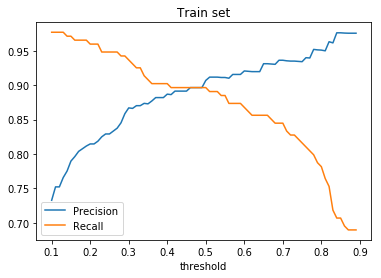

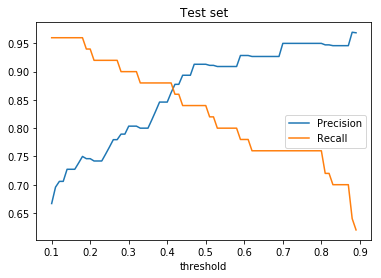

In [11]:
df_train = pd.DataFrame({'Precision':train_precisions, 'Recall':train_recalls}, index=ts)
lines_train = df_train.plot.line()
lines_train.set_title('Train set')
lines_train.set_xlabel('threshold')

df_test = pd.DataFrame({'Precision':test_precisions, 'Recall':test_recalls}, index=ts)
lines_test = df_test.plot.line()
lines_test.set_title('Test set')
lines_test.set_xlabel('threshold')